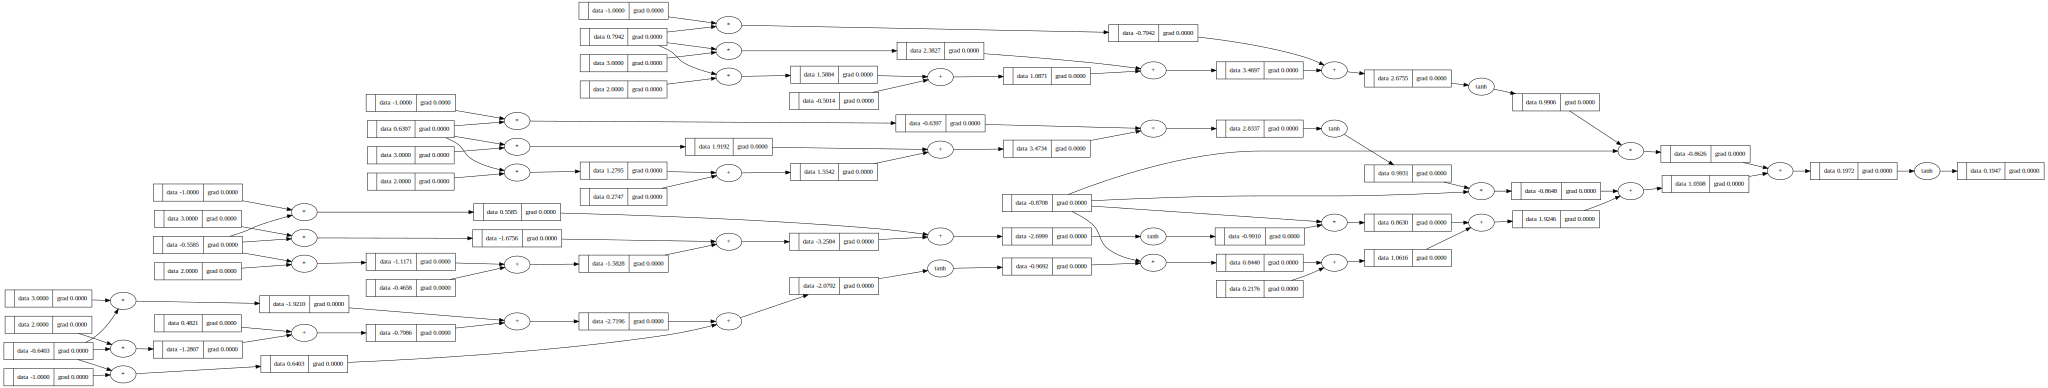

In [15]:
from typing import Any
from graphviz import Source, Digraph
import math
import random


class Value:
    def __init__(self, data, _children=(), op="", label=""):

        # if list then multiple pointers to same child may occur : not needed???

        self.data = data
        self._gradient = lambda: None
        self._prev = set(_children)
        self.grad = 0
        self._op = op
        self.label = label

    def __repr__(self) -> str:
        return f"Value({self.data})"

    def __add__(self, other):

        if not isinstance(other, Value):
            other = Value(other)

        out = Value(self.data+other.data, (self, other), "+")

        def _gradient():
            self.grad += 1*out.grad
            other.grad += 1*out.grad

        out._gradient = _gradient
        # calling function to calculate gradient of output wrt self and other storing in grad attribute of self and other
        return out

    def __sub__(self, other):
        # if not isinstance(other, Value):
        #     other = Value(other)

        # out = Value(self.data-other.data, (self, other), "+")

        # def _gradient():
        #     self.grad += 1*out.grad
        #     other.grad += (-1*out.grad)

        # out._gradient = _gradient
        # # calling function to calculate gradient of output wrt self and other storing in grad attribute of self and other
        # return out
        return self+(-other)

    def __mul__(self, other):

        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data*other.data, (self, other), "*")

        def _gradient():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._gradient = _gradient
        return out

    def __rmul__(self, other):

        # a is self and 2 is other
        return self*other

    def __radd__(self, other):
        return self+other

    def backpropogate(self):
        topo_list = []
        self.grad = 1
        visited = set()

        def build_backprop_list(x: Value):
            for children in x._prev:
                if children not in visited:
                    visited.add(children)
                    build_backprop_list(children)
            topo_list.append(x)

        build_backprop_list(self)

        for node in reversed(topo_list):
            node._gradient()

    def tanh(self):

        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), "tanh")

        def _gradient():
            self.grad += (1-t**2)*out.grad

        # we make it += because we can have multiple children and we want to add all the gradients(accummulate)

        out._gradient = _gradient
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._gradient = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))  # only supporting x^k
        out = Value(self.data**other, (self,), f"**{other}")

        def _gradient():
            local_gradient = other*(self.data**(other-1))
            self.grad += local_gradient*out.grad

        out._gradient = _gradient
        return out

    def __neg__(self):  # -self
        return self * -1

    def __truediv__(self, other):
        # a/b = a*(b**-1)
        return self*other**-1


class Neuron():
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1))]*nin
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out


class Layer():

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        # create a list of neurons of size nout with nin inputs each

    def __call__(self, x):
        outs = list(n(x) for n in self.neurons)
        # call each neuron with input x and store output in a list
        return outs[0] if len(outs) == 1 else outs


class MLP():
    # multi layer perceptron
    def __init__(self, nin, nouts):
        # nouts is a list of number of neurons in each layer
        sz = [nin]+nouts
        # sz is a list of number of inputs and outputs of each layer
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        # create a list of layers with nin inputs and nouts[i] outputs for each layer
        # len(nouts) is used as first layer (non hidden)

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
            # we pass on output of one layer as input to next layer since x variable is overwritten
        return x




from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

def test_mlp():
    x = MLP(3, [4, 1])
    n = [2.0, 3.0, -1.0]
    return(x(n))

y=test_mlp()
draw_dot(y)

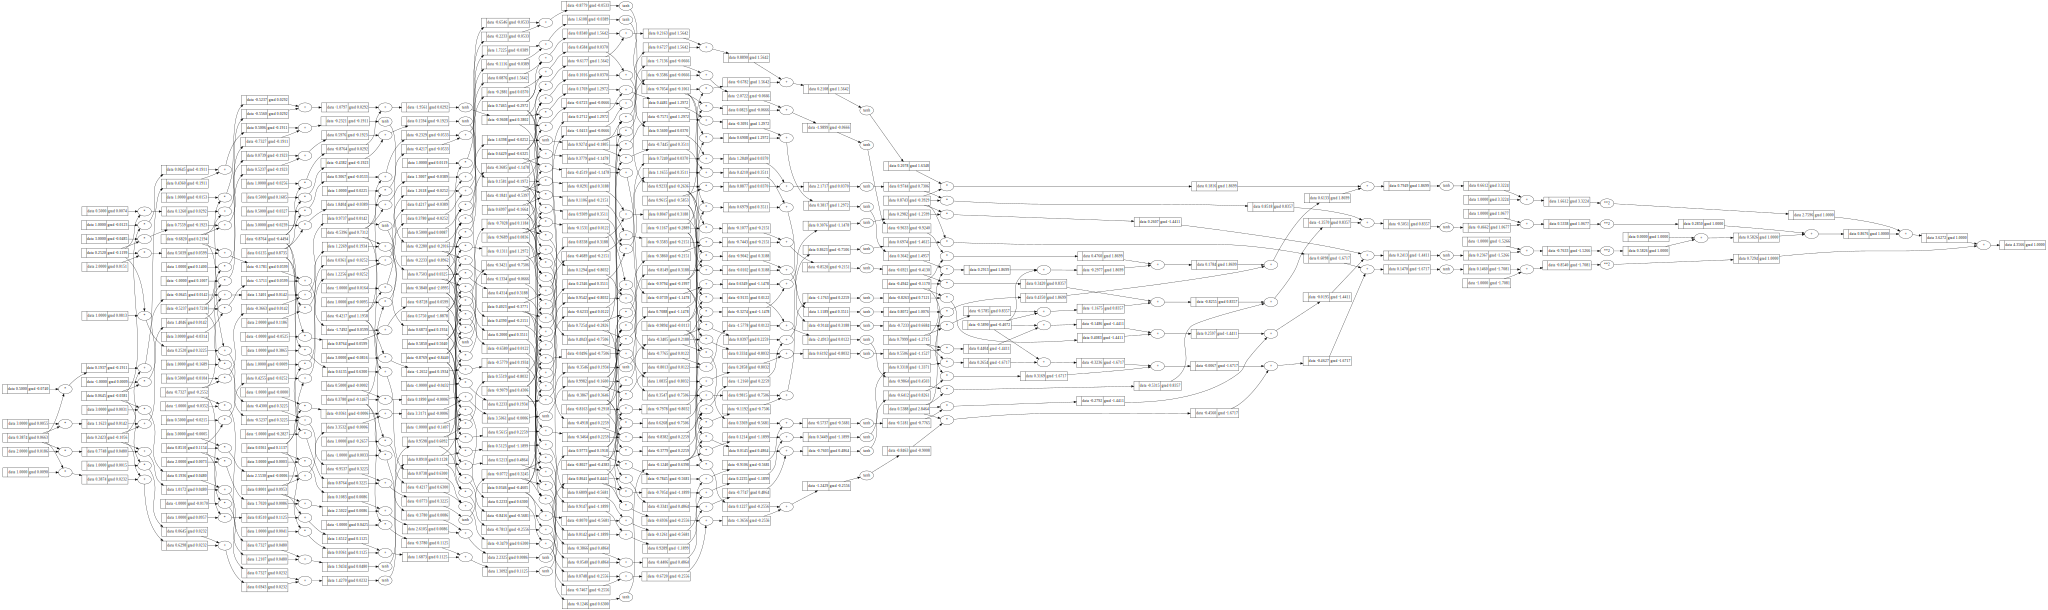

In [19]:
from typing import Any
from graphviz import Source, Digraph
import math
import random


class Value:
    def __init__(self, data, _children=(), op="", label=""):

        # if list then multiple pointers to same child may occur : not needed???

        self.data = data
        self._gradient = lambda: None
        self._prev = set(_children)
        self.grad = 0
        self._op = op
        self.label = label

    def __repr__(self) -> str:
        return f"Value({self.data})"

    def __add__(self, other):

        if not isinstance(other, Value):
            other = Value(other)

        out = Value(self.data+other.data, (self, other), "+")

        def _gradient():
            self.grad += 1*out.grad
            other.grad += 1*out.grad

        out._gradient = _gradient
        # calling function to calculate gradient of output wrt self and other storing in grad attribute of self and other
        return out

    def __sub__(self, other):
        # if not isinstance(other, Value):
        #     other = Value(other)

        # out = Value(self.data-other.data, (self, other), "+")

        # def _gradient():
        #     self.grad += 1*out.grad
        #     other.grad += (-1*out.grad)

        # out._gradient = _gradient
        # # calling function to calculate gradient of output wrt self and other storing in grad attribute of self and other
        # return out
        return self+(-other)

    def __mul__(self, other):

        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data*other.data, (self, other), "*")

        def _gradient():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._gradient = _gradient
        return out

    def __rmul__(self, other):

        # a is self and 2 is other
        return self*other

    def __radd__(self, other):
        return self+other

    def backpropogate(self):
        topo_list = []
        self.grad = 1
        visited = set()

        def build_backprop_list(x: Value):
            for children in x._prev:
                if children not in visited:
                    visited.add(children)
                    build_backprop_list(children)
            topo_list.append(x)

        build_backprop_list(self)

        for node in reversed(topo_list):
            node._gradient()

    def tanh(self):

        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), "tanh")

        def _gradient():
            self.grad += (1-t**2)*out.grad

        # we make it += because we can have multiple children and we want to add all the gradients(accummulate)

        out._gradient = _gradient
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._gradient = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))  # only supporting x^k
        out = Value(self.data**other, (self,), f"**{other}")

        def _gradient():
            local_gradient = other*(self.data**(other-1))
            self.grad += local_gradient*out.grad

        out._gradient = _gradient
        return out

    def __neg__(self):  # -self
        return self * -1

    def __truediv__(self, other):
        # a/b = a*(b**-1)
        return self*other**-1


class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]




from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


n = MLP(3, [4, 4, 1])

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]

    
    
loss =sum ((yout-ytrue)**2 for yout, ytrue in zip(ypred, ys))

loss.backpropogate()

draw_dot(loss)

MINE

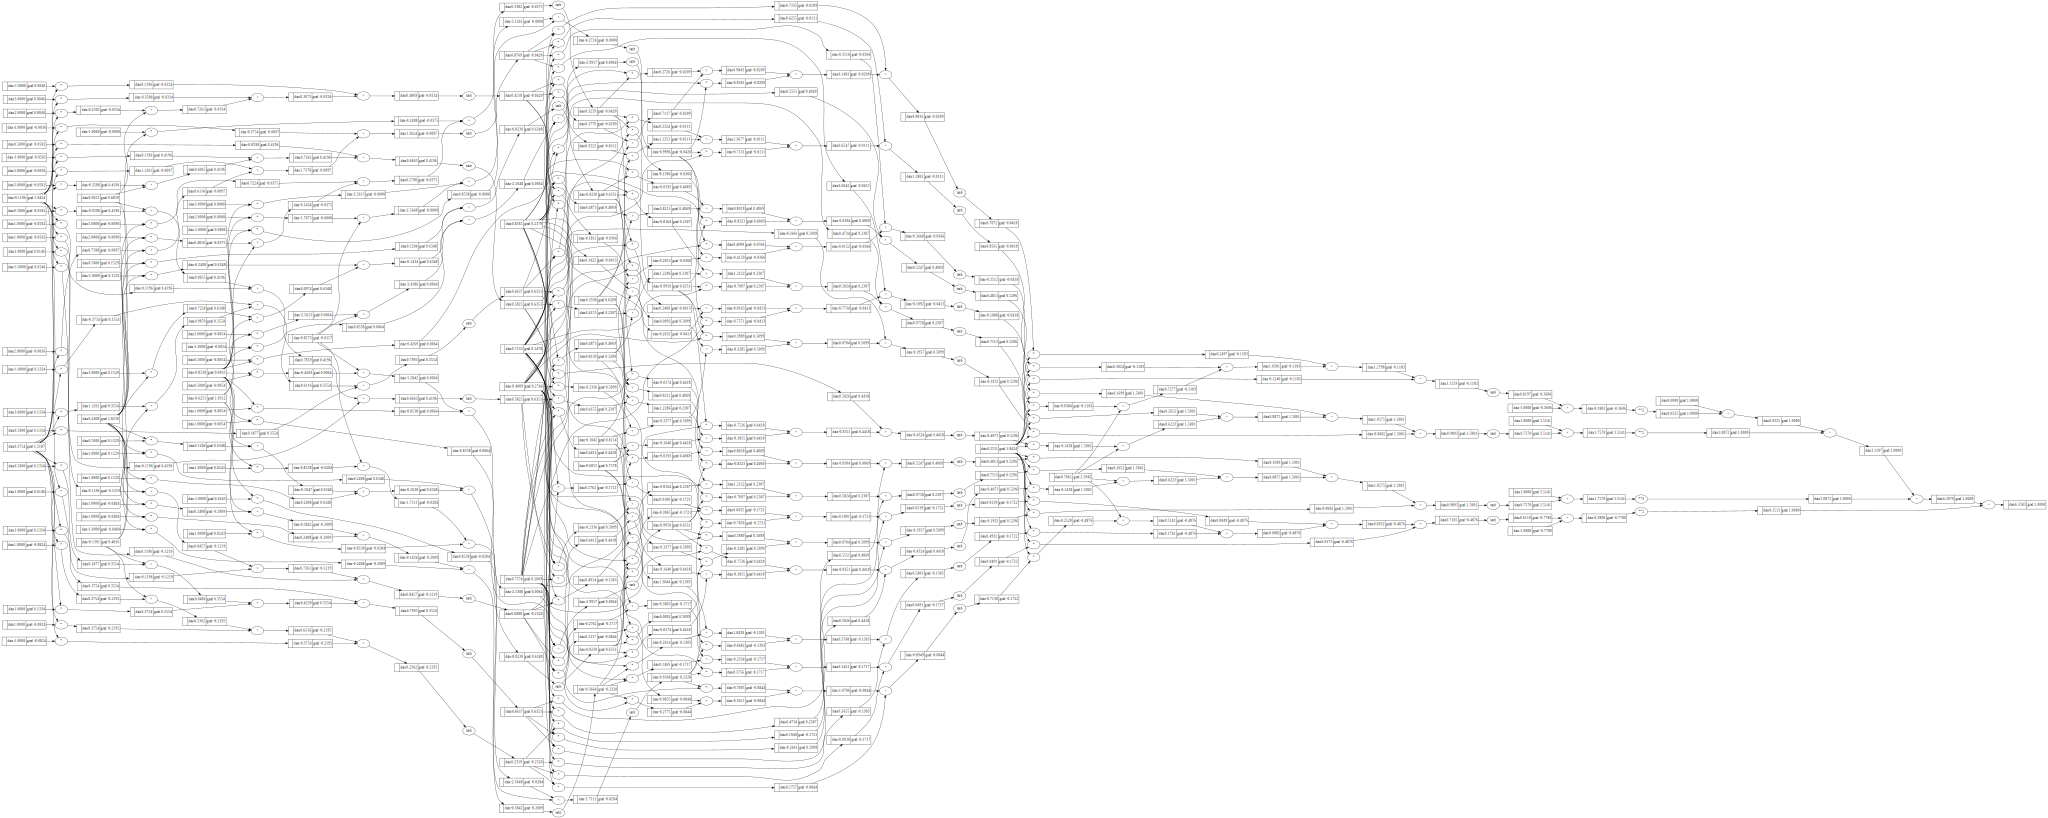

In [20]:
from typing import Any
from graphviz import Source, Digraph
import math
import random


class Value:
    def __init__(self, data, _children=(), op="", label=""):

        # if list then multiple pointers to same child may occur : not needed???

        self.data = data
        self._gradient = lambda: None
        self._prev = set(_children)
        self.grad = 0
        self._op = op
        self.label = label

    def __repr__(self) -> str:
        return f"Value({self.data})"

    def __add__(self, other):

        if not isinstance(other, Value):
            other = Value(other)

        out = Value(self.data+other.data, (self, other), "+")

        def _gradient():
            self.grad += 1*out.grad
            other.grad += 1*out.grad

        out._gradient = _gradient
        # calling function to calculate gradient of output wrt self and other storing in grad attribute of self and other
        return out

    def __sub__(self, other):
        # if not isinstance(other, Value):
        #     other = Value(other)

        # out = Value(self.data-other.data, (self, other), "+")

        # def _gradient():
        #     self.grad += 1*out.grad
        #     other.grad += (-1*out.grad)

        # out._gradient = _gradient
        # # calling function to calculate gradient of output wrt self and other storing in grad attribute of self and other
        # return out
        return self+(-other)

    def __mul__(self, other):

        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data*other.data, (self, other), "*")

        def _gradient():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._gradient = _gradient
        return out

    def __rmul__(self, other):

        # a is self and 2 is other
        return self*other

    def __radd__(self, other):
        return self+other

    def backpropogate(self):
        topo_list = []
        self.grad = 1
        visited = set()

        def build_backprop_list(x: Value):
            for children in x._prev:
                if children not in visited:
                    visited.add(children)
                    build_backprop_list(children)
            topo_list.append(x)

        build_backprop_list(self)

        for node in reversed(topo_list):
            node._gradient()

    def tanh(self):

        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), "tanh")

        def _gradient():
            self.grad += (1-t**2)*out.grad

        # we make it += because we can have multiple children and we want to add all the gradients(accummulate)

        out._gradient = _gradient
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._gradient = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))  # only supporting x^k
        out = Value(self.data**other, (self,), f"**{other}")

        def _gradient():
            local_gradient = other*(self.data**(other-1))
            self.grad += local_gradient*out.grad

        out._gradient = _gradient
        return out

    def __neg__(self):  # -self
        return self * -1

    def __truediv__(self, other):
        # a/b = a*(b**-1)
        return self*other**-1


class Neuron():
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1))]*nin
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out


class Layer():

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        # create a list of neurons of size nout with nin inputs each

    def __call__(self, x):
        outs = list(n(x) for n in self.neurons)
        # call each neuron with input x and store output in a list
        return outs[0] if len(outs) == 1 else outs


class MLP():
    # multi layer perceptron
    def __init__(self, nin, nouts):
        # nouts is a list of number of neurons in each layer
        sz = [nin]+nouts
        # sz is a list of number of inputs and outputs of each layer
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        # create a list of layers with nin inputs and nouts[i] outputs for each layer
        # len(nouts) is used as first layer (non hidden)

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
            # we pass on output of one layer as input to next layer since x variable is overwritten
        return x


def test_backprop():
    # inputs x1,x2
    x1 = Value(2.0, label='x1')
    x2 = Value(0.0, label='x2')
    # weights w1,w2
    w1 = Value(-3.0, label='w1')
    w2 = Value(1.0, label='w2')
    # bias of the neuron
    b = Value(6.8813735870195432, label='b')
    # x1*w1 + x2*w2 + b
    x1w1 = x1*w1
    x1w1.label = 'x1*w1'
    x2w2 = x2*w2
    x2w2.label = 'x2*w2'
    x1w1x2w2 = x1w1 + x2w2
    x1w1x2w2.label = 'x1*w1 + x2*w2'
    n = x1w1x2w2 + b
    n.label = 'n'
    # ----
    e = (2*n).exp()
    o = (e - 1) / (e + 1)
    # ----
    o.label = 'o'
    o.backpropogate()


n = MLP(3, [4, 4, 1])

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]

    
    
loss =sum ((yout-ytrue)**2 for yout, ytrue in zip(ypred, ys))

loss.backpropogate()

draw_dot(loss)
    